# 8. Determining the crop coefficient function with Python
*M. Vremec, October 2022, University of Graz*

Data source: ZAMG - https://data.hub.zamg.ac.at

What is done:

- load the station data from ZAMG
- estimate potential evaporation
- determine the crop coefficient function based on equation 65 in Allen et al. 1998
- plot and store result

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyet
pyet.show_versions()

Python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Scipy version: 1.7.3
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Pyet version: 1.2.0


## Loading daily data from ZAMG (Messstationen Tagesdaten)

station: Graz Universität 16412

Selected variables:
- globalstrahlung (global radiation), J/cm2 needs to be in MJ/m3d, ZAMG abbreviation - strahl
- arithmetische windgeschwindigkeit (wind speed), m/s, ZAMG abbreviation - vv
- relative feuchte (relative humidity), %, ZAMG abbreviation - rel
- lufttemparatur (air temperature) in 2 m, C, ZAMG abbreviation - t
- lufttemperatur (air temperature) max in 2 m, C, ZAMG abbreviation - tmax
- lufttemperatur (air temperature) min in 2 m, C, ZAMG abbreviation - tmin
- latitute and elevation of a station

In [2]:
#read data
data_16412 = pd.read_csv('data//example_1//klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


## Calculate PET for Graz Universität - 16412

In [3]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate potential ET with Penman-Monteith FAO-56
pe_pm = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, 
                      lat=lat, tmax=tmax, tmin=tmin, rh=rh)

## Determine the crop coefficient function

Based on: https://www.fao.org/3/x0490e/x0490e0b.htm
figure 34.


![Figure 34](https://www.fao.org/3/x0490e/x0490e6k.gif)

In [4]:
Kcini = 0.3 
Kcmid = 1.1
Kcend = 0.65

crop_ini = pd.Timestamp("2020-04-01")
crop_dev = pd.Timestamp("2020-05-01")
mid_season = pd.Timestamp("2020-06-01")
late_s_start = pd.Timestamp("2020-07-01")
late_s_end = pd.Timestamp("2020-08-01")

<AxesSubplot:>

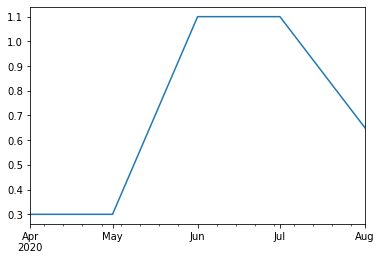

In [5]:
kc = pd.Series(index=[crop_ini, crop_dev, mid_season, late_s_start, late_s_end],
                 data=[Kcini, Kcini, Kcmid, Kcmid, Kcend])
kc = kc.resample("d").mean().interpolate()
kc.plot()

In [6]:
petc = pe_pm.loc[crop_dev:late_s_end] * kc

### Plot results

<AxesSubplot:xlabel='time'>

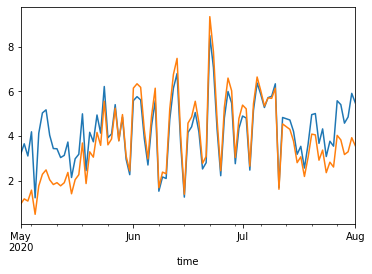

In [7]:
pe_pm.loc[crop_dev:late_s_end].plot(label="Potential evapotranspiration")
petc.loc[crop_dev:late_s_end].plot(label="Potential crop evapotranspiration")